# In this Notebook, we will be creating a XGBoost Model to Predict House Prices based off a Sample House Dataset.

In [1]:
# Import Modules
import pandas as pd
import numpy as np
import pickle
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold, train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
prices = pd.read_csv("American_Housing_Data_20231209 (1).csv")
prices

,Zip Code,Price,Beds,Baths,Living Space,Address,City,State,Zip Code Population,Zip Code Density,County,Median Household Income,Latitude,Longitude
0,10013,3999000.0,2,3,1967,74 GRAND ST APT 3,New York,New York,29563,20967.9,New York,370046.0,40.72001,-74.00472
1,10013,3999000.0,2,3,1967,74 GRAND ST APT 3,New York,New York,29563,20967.9,New York,370046.0,40.72001,-74.00472
2,10014,1650000.0,1,1,718,140 CHARLES ST APT 4D,New York,New York,29815,23740.9,New York,249880.0,40.73407,-74.00601
3,10014,760000.0,3,2,1538,38 JONES ST,New York,New York,29815,23740.9,New York,249880.0,40.73407,-74.00601
4,10014,1100000.0,1,1,600,81 BEDFORD ST APT 3F,New York,New York,29815,23740.9,New York,249880.0,40.73407,-74.00601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39976,98199,2495000.0,4,4,3380,2626 27TH AVE W,Seattle,Washington,22890,2086.8,King,205611.0,47.65139,-122.40223
39977,98199,2295000.0,4,4,2878,3215 32ND AVE W,Seattle,Washington,22890,2086.8,King,205611.0,47.65139,-122.40223
39978,98199,950000.0,3,2,1380,3257 22ND AVE W,Seattle,Washington,22890,2086.8,King,205611.0,47.65139,-122.40223
39979,98199,425000.0,2,1,856,3711 26TH PL W APT 102,Seattle,Washington,22890,2086.8,King,205611.0,47.65139,-122.40223


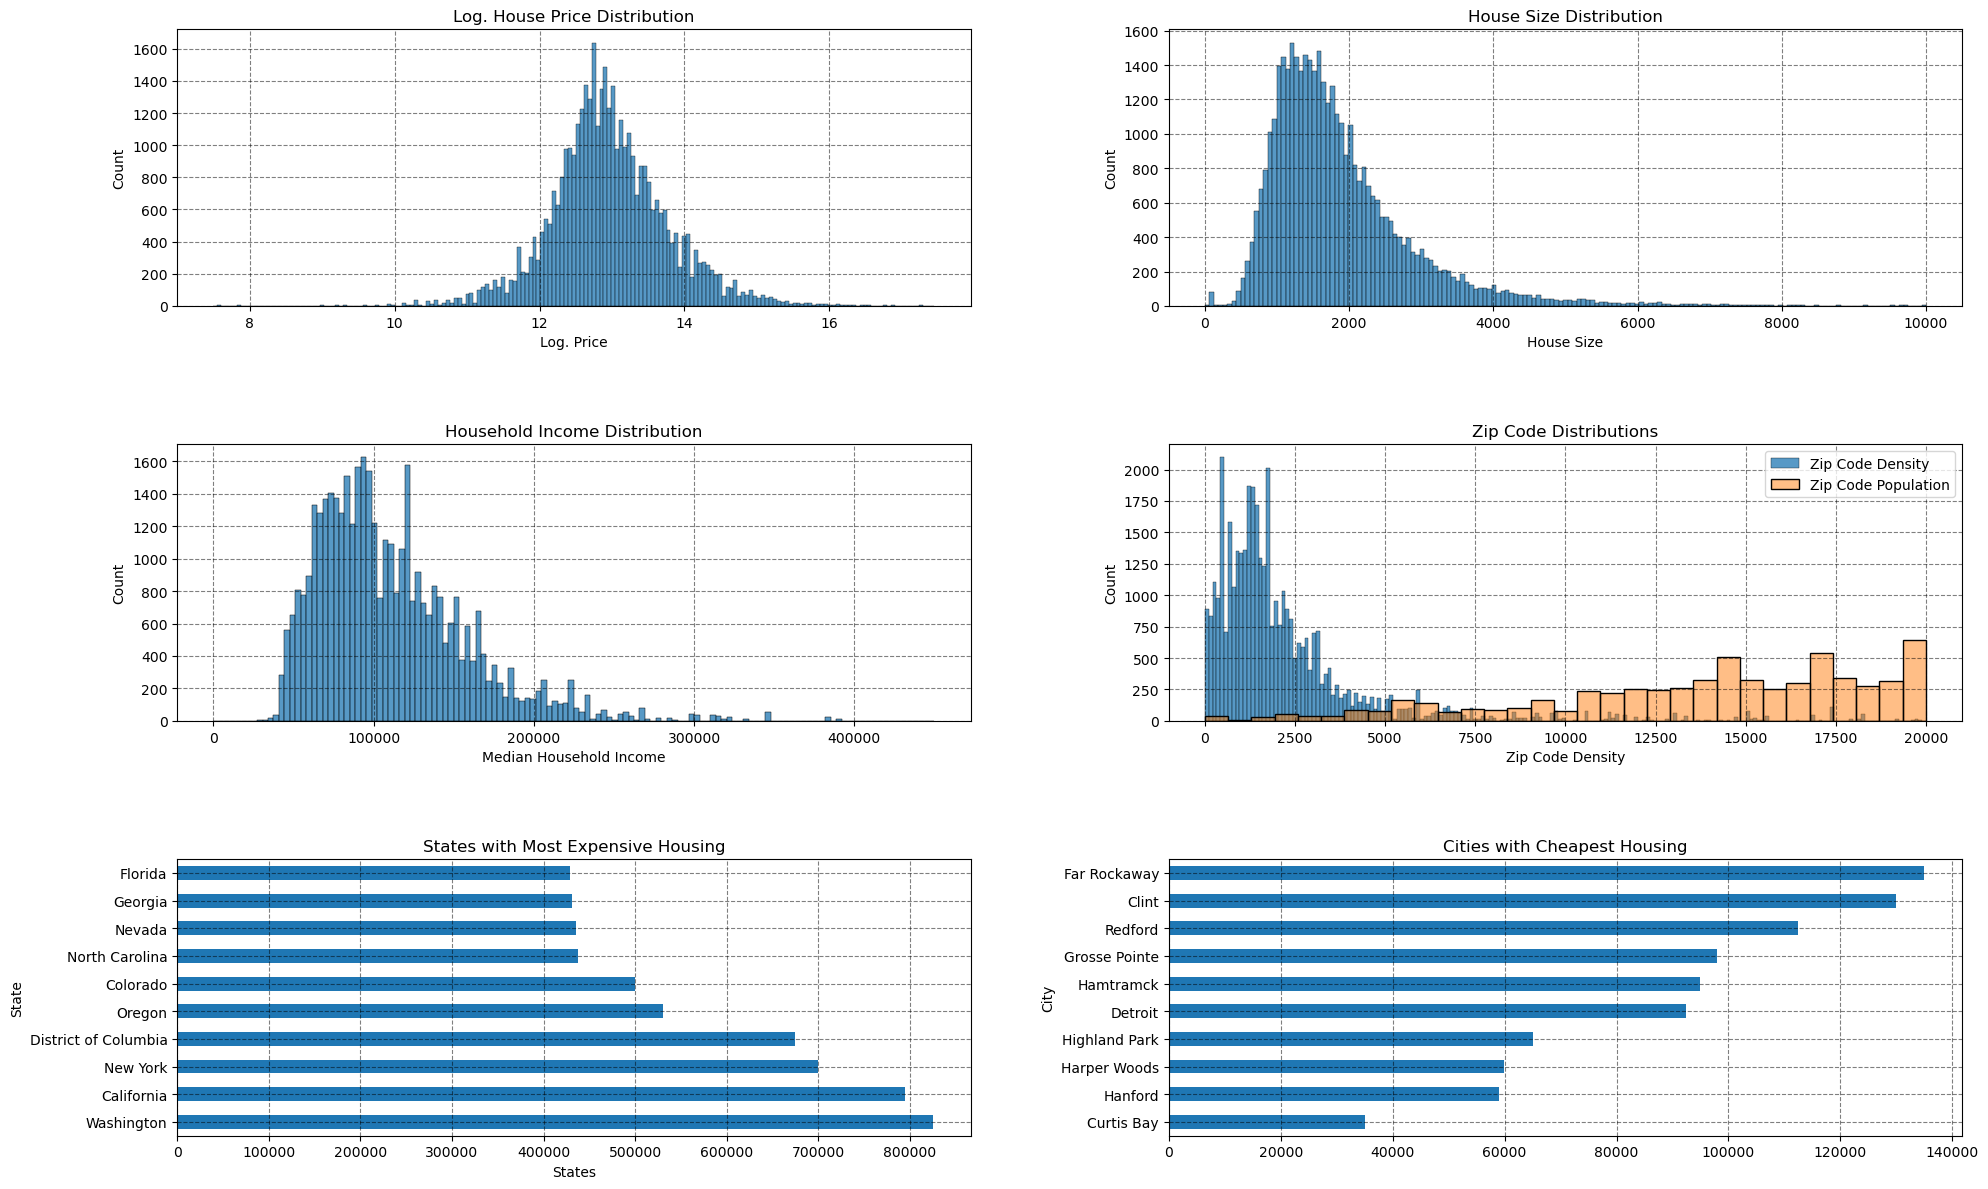

In [61]:
# Create Visualizations to see trends in Data
fig, ax = plt.subplots(3, 2, figsize=(20, 12))

# -- 1. Prices of house distribution
sns.histplot(np.log(prices.Price),ax = ax[0,0])
ax[0,0].set_xlabel("Log. Price"); ax[0,0].set_title("Log. House Price Distribution")
ax[0,0].grid(linestyle = '--', alpha = 0.5, color ='k')

# -- 2. House Size Distribution
sns.histplot(prices['Living Space'],ax = ax[0,1], binrange=[0, 10000])
ax[0,1].set_xlabel("House Size"); ax[0,1].set_title("House Size Distribution")
ax[0,1].grid(linestyle = '--', alpha = 0.5, color ='k')

# -- 3. Income Distribution
sns.histplot(prices['Median Household Income'],ax=ax[1, 0], binrange=[0,450000])
ax[1,0].set_title("Household Income Distribution")
ax[1,0].grid(linestyle = '--', alpha = 0.5, color ='k')


# -- 4. Zip Code pop + density
sns.histplot(prices['Zip Code Density'], ax=ax[1,1], binrange=[0,20000], label = "Zip Code Density")
sns.histplot(prices['Zip Code Population'], ax=ax[1,1], binrange=[0,20000], label = "Zip Code Population", alpha = 0.5)
ax[1,1].set_title("Zip Code Distributions")
ax[1,1].legend()
ax[1,1].grid(linestyle = '--', alpha = 0.5, color ='k')

# -- 5. State With Expensive Housing
state_exp = prices.groupby('State')['Price'].median()
state_exp.nlargest(10).plot(kind = 'barh', title = 'States with Most Expensive Housing', ax=ax[2,0], xlabel = "States")
ax[2,0].grid(linestyle = '--', alpha = 0.5, color ='k')


# --6. Cities With Cheapest Housing 
city_cheap = prices.groupby('City')['Price'].median()
city_cheap.sort_values().head(10).plot(ax=ax[2, 1], kind = 'barh', title = 'Cities with Cheapest Housing')
ax[2,1].grid(linestyle = '--', alpha = 0.5, color ='k')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.25)

In [3]:
# Create Location Options
locs = prices.City + " - " + prices.County + " - " + prices.State + " - " + prices["Zip Code"].astype(str)
pickle.dump(locs, open('location_opitions.pkl', 'wb'))

In [4]:
# Drop Col
prices = prices.drop(columns = 'Address')

In [5]:
# Check na vals
prices.isna().sum()

Zip Code                   0
Price                      0
Beds                       0
Baths                      0
Living Space               0
City                       0
State                      0
Zip Code Population        0
Zip Code Density           0
County                     0
Median Household Income    2
Latitude                   0
Longitude                  0
dtype: int64

In [6]:
# Drop na's
prices = prices.dropna()

In [7]:
# Col transformation
prices["State"] = prices["State"] + "-State"
prices["City"] = prices["City"] + "-City"
prices["County"] = prices["County"] + "-County"

prices["Zip Code"] = prices["Zip Code"].astype(str)
prices["Zip Code"] = prices["Zip Code"] + "-Zip_Code"

prices.head()

,Zip Code,Price,Beds,Baths,Living Space,City,State,Zip Code Population,Zip Code Density,County,Median Household Income,Latitude,Longitude
0,10013-Zip_Code,3999000.0,2,3,1967,New York-City,New York-State,29563,20967.9,New York-County,370046.0,40.72001,-74.00472
1,10013-Zip_Code,3999000.0,2,3,1967,New York-City,New York-State,29563,20967.9,New York-County,370046.0,40.72001,-74.00472
2,10014-Zip_Code,1650000.0,1,1,718,New York-City,New York-State,29815,23740.9,New York-County,249880.0,40.73407,-74.00601
3,10014-Zip_Code,760000.0,3,2,1538,New York-City,New York-State,29815,23740.9,New York-County,249880.0,40.73407,-74.00601
4,10014-Zip_Code,1100000.0,1,1,600,New York-City,New York-State,29815,23740.9,New York-County,249880.0,40.73407,-74.00601


In [8]:
# Create Dummy varibales
cat_vars = ["Zip Code", "City", "State", "County"]

for var in cat_vars:
    temp = prices[var]
    dummies = pd.get_dummies(temp, drop_first = True).astype(int)

    prices = pd.concat([prices, dummies], axis = 1)
    prices = prices.drop(columns = var)

In [9]:
# Correlations 
prices.corrwith(prices.Price).abs().sort_values(ascending = False).head(15)

Price                      1.000000
Living Space               0.520572
Baths                      0.462084
Median Household Income    0.416785
Beds                       0.277091
California-State           0.249696
San Francisco-County       0.197387
San Francisco-City         0.197387
Los Angeles-County         0.191656
Longitude                  0.168269
33139-Zip_Code             0.157255
La Jolla-City              0.153415
92037-Zip_Code             0.153415
Zip Code Density           0.152542
Miami Beach-City           0.152411
dtype: float64

In [10]:
# Reorder Columns 
num_cols = ["Living Space", "Beds", "Baths", "Median Household Income", "Zip Code Density", "Zip Code Population", "Latitude", "Longitude"]
state_cols = [col for col in prices.columns if col.endswith("-State")]
city_cols = [col for col in prices.columns if col.endswith("-City")]
county_cols = [col for col in prices.columns if col.endswith("-County")]
zip_cols = [col for col in prices.columns if col.endswith("-Zip_Code")]
target = ["Price"]

prices = prices[num_cols + state_cols + city_cols + county_cols + zip_cols + target]
prices

,Living Space,Beds,Baths,Median Household Income,Zip Code Density,Zip Code Population,Latitude,Longitude,California-State,Colorado-State,...,98133-Zip_Code,98136-Zip_Code,98144-Zip_Code,98146-Zip_Code,98164-Zip_Code,98168-Zip_Code,98177-Zip_Code,98178-Zip_Code,98199-Zip_Code,Price
0,1967,2,3,370046.0,20967.9,29563,40.72001,-74.00472,0,0,...,0,0,0,0,0,0,0,0,0,3999000.0
1,1967,2,3,370046.0,20967.9,29563,40.72001,-74.00472,0,0,...,0,0,0,0,0,0,0,0,0,3999000.0
2,718,1,1,249880.0,23740.9,29815,40.73407,-74.00601,0,0,...,0,0,0,0,0,0,0,0,0,1650000.0
3,1538,3,2,249880.0,23740.9,29815,40.73407,-74.00601,0,0,...,0,0,0,0,0,0,0,0,0,760000.0
4,600,1,1,249880.0,23740.9,29815,40.73407,-74.00601,0,0,...,0,0,0,0,0,0,0,0,0,1100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39976,3380,4,4,205611.0,2086.8,22890,47.65139,-122.40223,0,0,...,0,0,0,0,0,0,0,0,1,2495000.0
39977,2878,4,4,205611.0,2086.8,22890,47.65139,-122.40223,0,0,...,0,0,0,0,0,0,0,0,1,2295000.0
39978,1380,3,2,205611.0,2086.8,22890,47.65139,-122.40223,0,0,...,0,0,0,0,0,0,0,0,1,950000.0
39979,856,2,1,205611.0,2086.8,22890,47.65139,-122.40223,0,0,...,0,0,0,0,0,0,0,0,1,425000.0


In [11]:
# Split Data 
X, y = prices.drop(columns = 'Price'), prices['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [12]:
# Instantiate Model
xgb = XGBRegressor(n_jobs = -1, random_state = 42)
xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=-1, num_parallel_tree=None, ...)

In [13]:
# 2. Param Grid
param_grid = {
    'n_estimators': [100, 200, 275, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

# 3. Cross-validation
kf = KFold(n_splits=2, shuffle=True, random_state=42)

# 4. Randomized Search
rs = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=7,
    cv=kf,
    scoring='r2',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# 5. Fit
rs.fit(X_train, y_train)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


RandomizedSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=Non...
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None, ...),
                   n_iter=7, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'gamma': [0, 0.1, 0.3],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 5, 7, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [100, 200, 275, 300,
                                                         500],
                                        'reg_alpha': [0, 0.1],
                                        'reg_lambda': [1, 2],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42, scoring='r2', verbose=1)

In [14]:
print("Best score:", rs.best_score_)
print("Best Parameters:", rs.best_params_)

# Final model
best_model = rs.best_estimator_

Best score: 0.6450103596705551
Best Parameters: {'subsample': 1.0, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.3, 'colsample_bytree': 0.7}


In [15]:
# Fit Model
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.3, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [16]:
print(f"Training Score: {best_model.score(X_train, y_train)}")
print(f"Testing Score: {best_model.score(X_test, y_test)}")

Training Score: 0.8857446734793488
Testing Score: 0.752842035269403


C:\Users\ggpal\AppData\Local\Temp\ipykernel_1316\2132480565.py:5: RuntimeWarning: invalid value encountered in log
  x = np.log(y_pred),


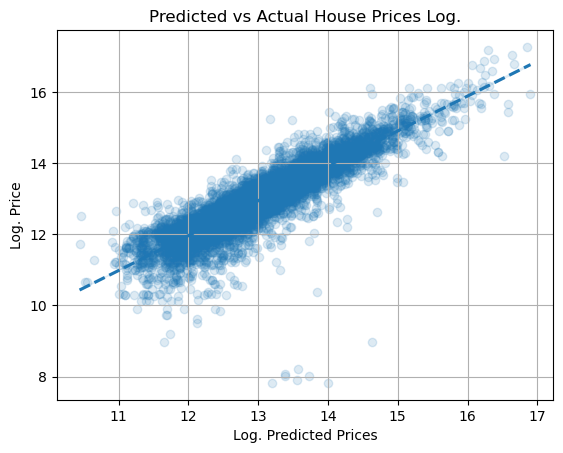

In [17]:
# Plot Results 
y_pred = best_model.predict(X_test)

sns.regplot(
    x = np.log(y_pred),
    y = np.log(y_test),
    line_kws = {'linestyle':'--'}, scatter_kws = {'alpha':0.15}
)

plt.xlabel("Log. Predicted Prices")
plt.ylabel("Log. Price")
plt.title("Predicted vs Actual House Prices Log.")

plt.grid()
plt.show()

In [18]:
# Save Info
pickle.dump(list(X_train.columns), open('features.pkl', 'wb'))
pickle.dump(best_model, open('model.pkl', 'wb'))

In [19]:
len(X_train.columns)

2096